**This notebook analyses possible correlations between hateful speech on 4chan and socioeconomic factors in the USA**

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import datetime as dt
import matplotlib.pylab as plt

import all counts into one dataframe

In [2]:
pol_counts = ["./Counts/pol_counts_part0.csv","./Counts/pol_counts_part1.csv"]
news_counts = "./Counts/news_counts.csv"
sci_counts = "./Counts/sci_counts.csv"
adv_counts = "./Counts/adv_counts.csv"

In [3]:
pol_counts = pd.read_csv(pol_counts[0],index_col=0).append(pd.read_csv(pol_counts[1], index_col=0))
sci_counts = pd.read_csv(sci_counts, index_col=0)
news_counts = pd.read_csv(news_counts, index_col=0)
adv_counts = pd.read_csv(adv_counts, index_col=0)

define hate_count column as number of hateful words

In [4]:
def countWords(text):
    try:
        return min(1,len(text.split(" ")))
    except Exception:
        return 0

In [5]:
pol_counts.loc[:,"board"] = "pol"
sci_counts.loc[:,"board"] = "sci"
adv_counts.loc[:,"board"] = "adv"
news_counts.loc[:,"board"] = "news"

In [6]:
for df in [pol_counts,sci_counts,adv_counts,news_counts]:
    df.loc[:,"hate_count"] = df.loc[:,"matched_vocab"].map(countWords)
    df.loc[:,'date'] = pd.to_datetime(df.loc[:,"timestamp"], unit='s')
    df.loc[:,'month'] = pd.to_datetime(df.loc[:,"date"]).dt.to_period('M')

convert timestamp to date and month

group by month and calculate sum of hate_count

In [7]:
pol_hate_share_monthly = pol_counts.groupby("month").sum()["hate_count"] / pol_counts.groupby("month")["content"].count()
sci_hate_share_monthly = sci_counts.groupby("month").sum()["hate_count"] / sci_counts.groupby("month")["content"].count()
adv_hate_share_monthly = adv_counts.groupby("month").sum()["hate_count"] / adv_counts.groupby("month")["content"].count()
news_hate_share_monthly = news_counts.groupby("month").sum()["hate_count"] / news_counts.groupby("month")["content"].count()

In [8]:
sci_hate_share_monthly.head()

month
2010-05    0.059417
2010-06    0.058848
2010-07    0.072431
2010-08    0.065405
2010-09    0.071923
Freq: M, dtype: float64

In [9]:
hate_share_monthly = pd.DataFrame(index=sci_hate_share_monthly.index, columns=["sci","news","adv","pol"])
hate_share_monthly.loc[sci_hate_share_monthly.index, "sci"] = sci_hate_share_monthly
hate_share_monthly.loc[:,'news'] = news_hate_share_monthly
hate_share_monthly.loc[:, "adv"] = adv_hate_share_monthly
hate_share_monthly.loc[:, "pol"] = pol_hate_share_monthly
hate_share_monthly.tail()

,sci,news,adv,pol
month,,,,
2021-08,0.106599,0.122677,0.181448,0.187663
2021-09,0.093541,0.120763,0.188089,0.192037
2021-10,0.103524,0.131843,0.175117,0.204550
2021-11,0.109521,0.116179,0.165316,0.195880
2021-12,0.099878,0.144330,0.151316,0.174427


***standardize all columns***

In [10]:
def standardize(data: pd.Series) -> pd.Series:
    return (data - data.median()) / data.std()

In [11]:
hate_share_monthly = hate_share_monthly.apply(standardize,axis=0)

In [12]:
hate_share_monthly.head()

,sci,news,adv,pol
month,,,,
2010-05,-0.972368,NaN,NaN,NaN
2010-06,-1.008734,NaN,NaN,NaN
2010-07,-0.140081,NaN,NaN,NaN
2010-08,-0.589395,NaN,NaN,NaN
2010-09,-0.172575,NaN,NaN,NaN


<AxesSubplot:xlabel='month'>

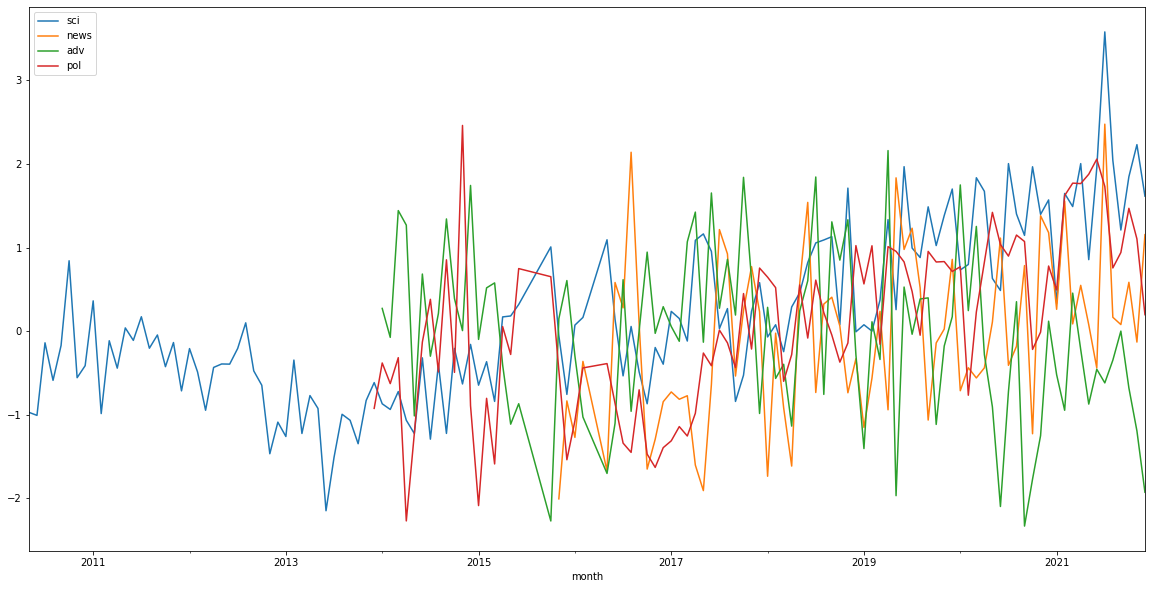

In [13]:
hate_share_monthly.plot.line(figsize=(20,10))

***Import and prepare series on monthly change in hourly wages***

In [14]:
us_hourly_wages = pd.read_csv("./usa_indicators/us_real_hourly_earnings_monthly.csv", index_col=3)
us_hourly_wages = us_hourly_wages.drop(["Series ID","Year","Period"], axis=1)
us_hourly_wages.head()

,Value
Label,
2010 Jan,10.30
2010 Feb,10.33
2010 Mar,10.33
2010 Apr,10.34
2010 May,10.37


In [15]:
new_index = pd.Series(us_hourly_wages.index)
new_index = pd.to_datetime(new_index).dt.to_period("M")
new_index.head()

0    2010-01
1    2010-02
2    2010-03
3    2010-04
4    2010-05
Name: Label, dtype: period[M]

In [16]:
us_hourly_wages.index = pd.Index(new_index, name="Month")
us_hourly_wages = us_hourly_wages.loc[:,"Value"]
us_hourly_wages = us_hourly_wages.map(np.float64)
us_hourly_wages.head()

Month
2010-01    10.30
2010-02    10.33
2010-03    10.33
2010-04    10.34
2010-05    10.37
Freq: M, Name: Value, dtype: float64

In [22]:
def unemploymentData(path) -> pd.Series:
    df = pd.read_csv(path, index_col=3).drop(["Series ID","Year","Period"], axis=1)
    new_index = pd.Series(df.index)
    new_index = pd.to_datetime(new_index).dt.to_period("M")
    df.index = pd.Index(new_index, name="Month")
    df = df.loc[:,"Value"]
    df = df.map(np.float64)
    return df

***Import and prepare monthly unemployment***

In [23]:
us_unemployment_monthly = unemploymentData("./usa_indicators/us_unemployment_monthly.csv")
us_unemployment_monthly.head()

Month
2010-01    9.8
2010-02    9.8
2010-03    9.9
2010-04    9.9
2010-05    9.6
Freq: M, Name: Value, dtype: float64

In [24]:
us_unemployment_monthly_youth = unemploymentData("./usa_indicators/us_unemployment_monthly_16to19_yrs.csv")
us_unemployment_monthly_youth.head()

Month
2010-01    26.1
2010-02    25.6
2010-03    26.2
2010-04    25.4
2010-05    26.5
Freq: M, Name: Value, dtype: float64

In [25]:
us_unemployment_monthly_mid = unemploymentData("./usa_indicators/us_unemployment_monthly_25to54_yrs.csv")
us_unemployment_monthly_mid.head()

Month
2010-01    8.8
2010-02    8.8
2010-03    8.9
2010-04    8.8
2010-05    8.7
Freq: M, Name: Value, dtype: float64

***Build combined dataset of all factors***

In [28]:
us_indicators = pd.DataFrame(index=us_unemployment_monthly.index)
us_indicators.loc[:,"unemployment youth"] = us_unemployment_monthly_youth
us_indicators.loc[:,"unemployment mid aged"] = us_unemployment_monthly_mid
us_indicators.loc[:,"hourly wages"] = us_hourly_wages
us_indicators.index = pd.Index(us_indicators.index, name="Month")
us_indicators = us_indicators.apply(standardize, axis=0)
us_indicators.head()

,unemployment youth,unemployment mid aged,hourly wages
Month,,,
2010-01,1.811110,1.930303,-0.912584
2010-02,1.716781,1.930303,-0.834362
2010-03,1.829975,1.979798,-0.834362
2010-04,1.679050,1.930303,-0.808289
2010-05,1.886573,1.880808,-0.730067


***Plot lines***

<AxesSubplot:xlabel='Month', ylabel='Normalized'>

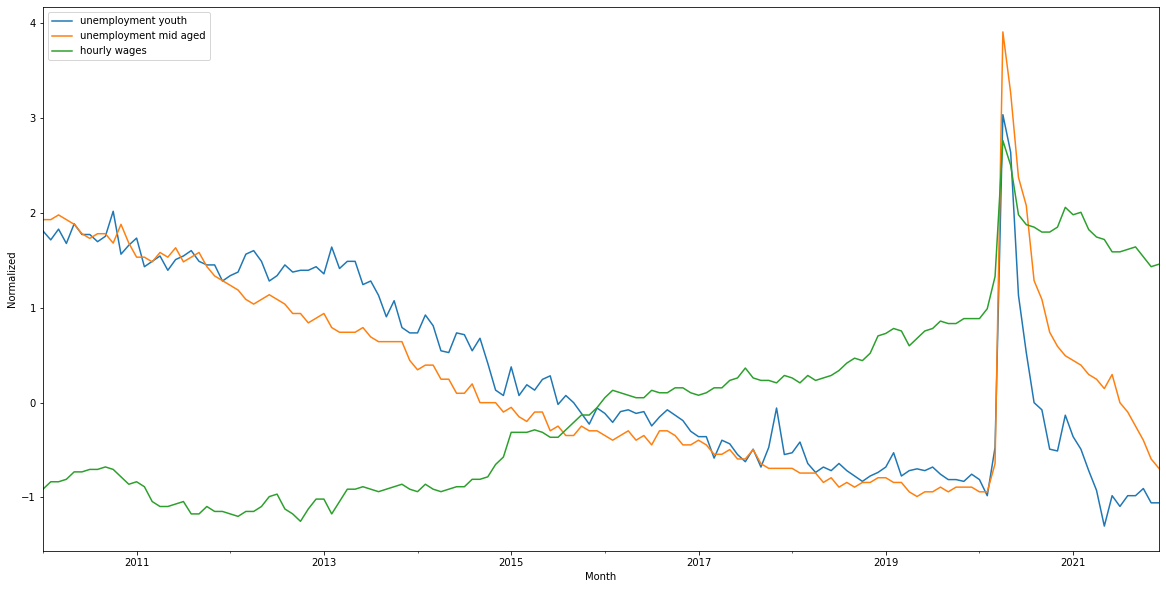

In [29]:
us_indicators.plot.line(figsize=(20,10), ylabel="Normalized")

***Shift indicators one period to the left***

In [30]:
us_indicators_shifted = us_indicators.copy()

In [31]:
for indicator in us_indicators.columns:
    us_indicators_shifted.loc[:,f"{indicator} shift -1"] = np.repeat(np.NaN, len(us_indicators_shifted.index))
    us_indicators_shifted.loc[:,f"{indicator} shift -1"].iloc[1:] = us_indicators_shifted.loc[:,indicator].iloc[:-1]
    us_indicators_shifted = us_indicators_shifted.drop(indicator, axis=1)

In [32]:
us_indicators_shifted.head()

,unemployment youth shift -1,unemployment mid aged shift -1,hourly wages shift -1
Month,,,
2010-01,NaN,NaN,NaN
2010-02,1.811110,1.930303,-0.912584
2010-03,1.716781,1.930303,-0.834362
2010-04,1.829975,1.979798,-0.834362
2010-05,1.679050,1.930303,-0.808289


***Regress all hate share targets on indicators***

In [33]:
regressions = pd.DataFrame(index=pd.Index(hate_share_monthly.columns, name="Target"), columns=us_indicators.columns)

In [34]:
model = linear_model.Ridge(alpha=.5)

In [35]:
for target in hate_share_monthly.columns:
    target_data = hate_share_monthly.loc[:,target].dropna()
    model.fit(us_indicators.loc[target_data.index].to_numpy(), np.reshape(target_data.to_numpy(),(-1,1)))
    regressions.loc[target] = model.coef_

In [36]:
regressions.head(10)

,unemployment youth,unemployment mid aged,hourly wages
Target,,,
sci,-0.586694,0.397984,0.507438
news,0.020651,-0.312837,0.723684
adv,0.421984,-0.543481,-0.095918
pol,-0.255604,0.153873,0.561602


***Regress hate share targets on shifted regressors ***

In [37]:
shifted_regressions = pd.DataFrame(index=pd.Index(hate_share_monthly.columns, name="Target"), columns=us_indicators_shifted.columns)

In [38]:
for target in hate_share_monthly.columns:
    target_data = hate_share_monthly.loc[:,target].dropna()
    model.fit(us_indicators_shifted.loc[target_data.index].to_numpy(), np.reshape(target_data.to_numpy(),(-1,1)))
    shifted_regressions.loc[target] = model.coef_

In [39]:
shifted_regressions.head(10)

,unemployment youth shift -1,unemployment mid aged shift -1,hourly wages shift -1
Target,,,
sci,-0.85943,0.580927,0.388756
news,0.010417,-0.242073,0.68267
adv,-0.243756,-0.020723,-0.399382
pol,-0.155179,0.077096,0.615418


***Inspect covariances***

In [40]:
all_combined = hate_share_monthly.join(us_indicators)
all_combined_shifted = hate_share_monthly.join(us_indicators_shifted)

In [41]:
all_combined.head()

,sci,news,adv,pol,unemployment youth,unemployment mid aged,hourly wages
month,,,,,,,
2010-05,-0.972368,NaN,NaN,NaN,1.886573,1.880808,-0.730067
2010-06,-1.008734,NaN,NaN,NaN,1.773378,1.781818,-0.730067
2010-07,-0.140081,NaN,NaN,NaN,1.773378,1.732323,-0.703993
2010-08,-0.589395,NaN,NaN,NaN,1.697915,1.781818,-0.703993
2010-09,-0.172575,NaN,NaN,NaN,1.754512,1.781818,-0.677920


In [42]:
correlations = all_combined.corr()
correlations_shifted = all_combined_shifted.corr()

In [43]:
correlations.head(10)

,news,adv,pol,unemployment youth,unemployment mid aged,hourly wages
news,1.000000,-0.250710,0.340371,-0.070163,0.090968,0.335447
adv,-0.250710,1.000000,-0.237006,-0.036184,-0.267495,-0.320322
pol,0.340371,-0.237006,1.000000,-0.181292,0.181322,0.591964
unemployment youth,-0.070163,-0.036184,-0.181292,1.000000,0.875903,-0.624627
unemployment mid aged,0.090968,-0.267495,0.181322,0.875903,1.000000,-0.258408
hourly wages,0.335447,-0.320322,0.591964,-0.624627,-0.258408,1.000000


In [44]:
correlations_shifted.head(10)

,news,adv,pol,unemployment youth shift -1,unemployment mid aged shift -1,hourly wages shift -1
news,1.000000,-0.250710,0.340371,-0.030765,0.134025,0.353214
adv,-0.250710,1.000000,-0.237006,-0.124378,-0.289854,-0.336383
pol,0.340371,-0.237006,1.000000,-0.171291,0.183215,0.604840
unemployment youth shift -1,-0.030765,-0.124378,-0.171291,1.000000,0.877648,-0.621201
unemployment mid aged shift -1,0.134025,-0.289854,0.183215,0.877648,1.000000,-0.258200
hourly wages shift -1,0.353214,-0.336383,0.604840,-0.621201,-0.258200,1.000000


***Generate heat map***

In [45]:
import seaborn as sb

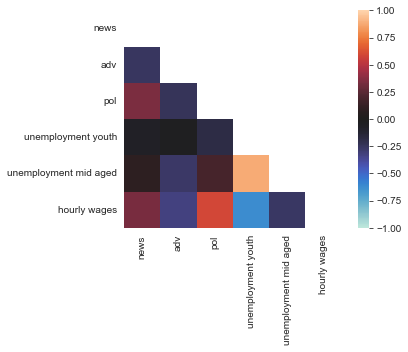

In [46]:
mask = np.zeros_like(correlations.to_numpy())
mask[np.triu_indices_from(mask)] = True
with sb.axes_style("white"):
    ax = sb.heatmap(correlations.to_numpy(), mask=mask, vmax=1.0, vmin=-1, center=0, square=True, xticklabels=correlations.index, yticklabels=correlations.index)
    plt.show()

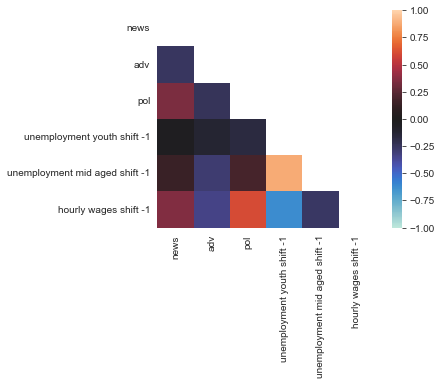

In [47]:
mask = np.zeros_like(correlations_shifted.to_numpy())
mask[np.triu_indices_from(mask)] = True
with sb.axes_style("white"):
    ax = sb.heatmap(correlations_shifted.to_numpy(), mask=mask, vmax=1.0, vmin=-1, center=0, square=True, xticklabels=correlations_shifted.index, yticklabels=correlations_shifted.index)
    plt.show()